# Loading the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

TITANIC_FOLDER_PATH = path = os.path.join("datasets", "titanic")


def load_titanic_data(filename):
    file_path = os.path.join(TITANIC_FOLDER_PATH, filename)
    return pd.read_csv(file_path)

In [2]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")
gender_submission_data = load_titanic_data("gender_submission.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Ok, we have the data. The test set does not have a label. That's meant to run your model on it and make the submissions and see the result.

# Explore the data

In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Does the dataset have empty values?

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_data.isna().sum() / len(train_data)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

There are empty values. Almost 20% of age, 77% of Cabin and 0.02 % of Embarked. Let's check closer.

In [7]:
train_data["Age"].value_counts()


24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

In [8]:
train_data["Cabin"].value_counts()


B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Cabin seems to be a categorical value. Doesn't help a lot since there are a lot of values. But what if we just keep the cabin number? Like A, B, C, D ? Maybe we could engineer that feature.

In [9]:
train_data["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Same thing for Ticket. A categorical value with a lot of values. Not very helpful at first sight.

In [10]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Just 3 categories here representing 3 different embarking locations. The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

## Even before exploring the data more let's train a classifier and see the result we get
We'll train a model by applying just a simple transformation. Filling in empty values with the median for numerical columns and scaling them. For categorical values we'll fill in the missing values with the most frequest since median can't work and encoding them using a one hot encoder.

We won't use all the columns for the training since some are useless for us at the moment before we learn more and we do some feature engineering. Here's what we'll drop:
* **PassengerId**: does not contain any info
* **Survived**: that's the target that we're predicting so no need for it
* **Name**: Not good info at the moment, name should not affect survival rate. But maybe it does, we should check
* **Ticket**: Too many values to treat as a category, so we'll drop it
* **Cabin**: Too many values to treat as a category, so we'll drop it

We'll keep the rest of them though and pass through a pipeline transformer

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder()),
])

from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [12]:
cleaned_training_data = train_data[num_attribs + cat_attribs]
cleaned_training_data

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,22.0,1,0,7.2500,3,male,S
1,38.0,1,0,71.2833,1,female,C
2,26.0,0,0,7.9250,3,female,S
3,35.0,1,0,53.1000,1,female,S
4,35.0,0,0,8.0500,3,male,S
...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,2,male,S
887,19.0,0,0,30.0000,1,female,S
888,NaN,1,2,23.4500,3,female,S
889,26.0,0,0,30.0000,1,male,C


Let's transform the training data

In [13]:
X_train = preprocess_pipeline.fit_transform(cleaned_training_data)
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Looks good. Let's train a classifier for this. Let's keep the labels in a different variable before.

In [14]:
y_train = train_data["Survived"]
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8092759051186016

How about a different model? Like an SVC

In [16]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Over 80% accuracy on the validation set using both models. That's not bad at all. And we did this before doing any meaningful exploration and feature engineering.
* Are the features we used relevant? What if we don't need all
* Do the features we dropped contain relevant information? Can we adjust and use them?
* Is the model good? We should try a few more
* We should fine-tune the hyperparameters as well

# Let's explore the data in more depth

In [17]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


## Let's check how many passengers survived

In [18]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [19]:
train_data["Survived"].value_counts(normalize=True)


0    0.616162
1    0.383838
Name: Survived, dtype: float64

I'll create a method to plot different dataframes based on survival since i'll need this later.

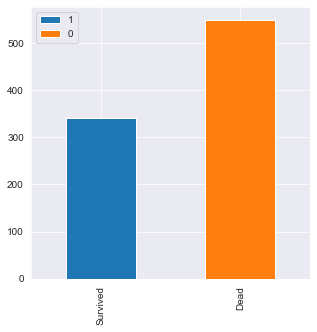

In [20]:
def survival_chart_stacked(data, feature, stacked=True):
    survived = data[data["Survived"] == 1][feature].value_counts()
    dead = data[data["Survived"] == 0][feature].value_counts()
    survived_dead = pd.DataFrame([survived, dead])
    survived_dead.index = ["Survived", "Dead"]
    survived_dead.plot(kind="bar", stacked=stacked, figsize=(5, 5))


survival_chart_stacked(train_data, "Survived")

So yea, 38% only survived. The data set suffers from imbalance but this imbalance is important, so we shouldn't sample it.

## Is the likelihood of survival dependent on gender?

In [21]:
train_data["Sex"].value_counts()


male      577
female    314
Name: Sex, dtype: int64

In [22]:
train_data["Sex"].value_counts(normalize=True)


male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [23]:
train_data.groupby("Sex")["Survived"].mean()


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

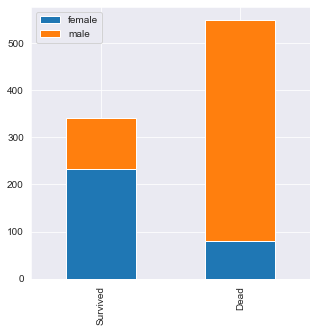

In [24]:
survival_chart_stacked(train_data, "Sex")


It's clear here that the majority of people who survived were women. 4 times higher that the survival rate for men. It confirms that they  applied the women and children first.

## Is the likelihood of survival dependent on class?

In [25]:
train_data["Pclass"].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

In [26]:
train_data.groupby("Pclass")["Survived"].mean()


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

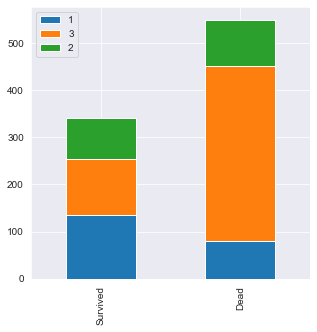

In [27]:
survival_chart_stacked(train_data, "Pclass")


The class seems to be relevant. Most of the passengers (55%) had class 3 tickets but only 24% of them survived. 63% of class 1 survived which is very relevant and 47% of class 2.
We should explore if the higher survival rate in class 1 is due to the actual class and not another reason.

## Is the higher survival rate in Class 1 due to the class itself or due to a skewed gender distribution in which female passengers dominate?

In [28]:
train_data.groupby(["Pclass", "Sex"])["Survived"].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

In [29]:
train_data.groupby(["Pclass"])["Sex"].value_counts()

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

We can see that no, there's not a horrible bias in numbers towards women in class 1. So let's check the survival rate grouping by class and sex.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

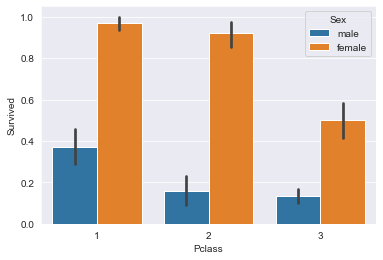

In [30]:
import seaborn as sns

sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train_data)


We can see that our question made sense. Regardless of the class, the most important thing was gender. We can see however that men had a higher chance of survival if they bought class 1 tickets. This shows that both Sex and the class are good features affecting the survival chance.
* Survival females class 1: 96.8%
* Survival females class 2: 92.1%
* Survival females class 3: 50%
* Survival males class 1: 36.8% (even the highest survival rate based on class for men si still lower that the lowest survival rate of women)

## Did a passengers age influence the chance of survival?

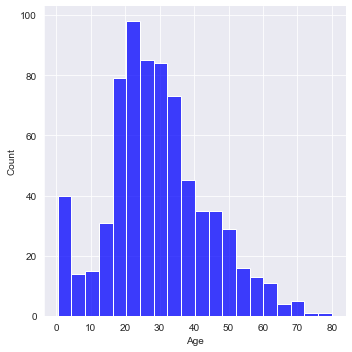

In [31]:
sns.displot(train_data["Age"], color='b', bins=20)


It's a pretty normal Gaussian distribution. Let's plot survivors and deaths based on age.

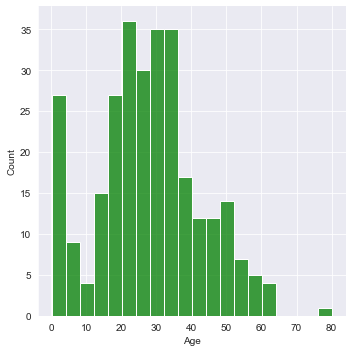

In [32]:
sns.displot(train_data[train_data["Survived"] == 1]["Age"], color='g', bins=20)

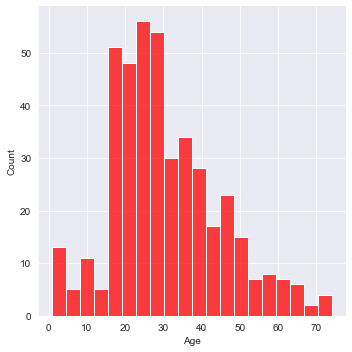

In [33]:
sns.displot(train_data[train_data["Survived"] == 0]["Age"], color='r', bins=20)

Not very visible. Let's put then on top of each other.

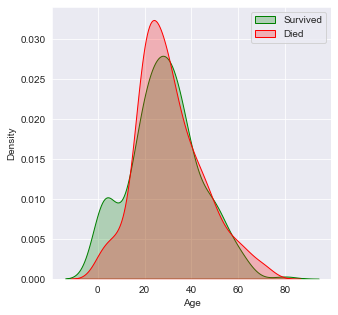

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(train_data[train_data["Survived"] == 1]["Age"], shade=True, ax=ax, label="Survived", color='g')
sns.kdeplot(train_data[train_data["Survived"] == 0]["Age"], shade=True, ax=ax, label="Died", color='r')
plt.legend()


We didn't learn a lot by looking at this except the fact that seems to be a raise in survivors at a very small age. We should try and investigate the age and the sex together because it makes sense that age SHOULD HAVE an influence on survival:

<AxesSubplot:xlabel='Age', ylabel='Sex'>

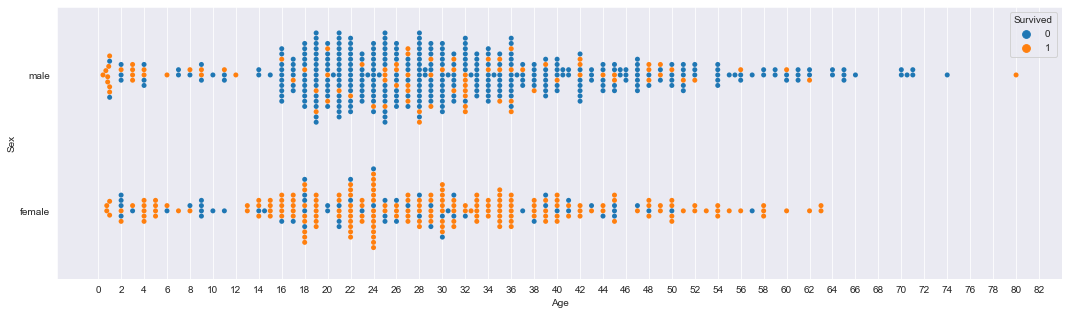

In [35]:
fix, ax = plt.subplots(figsize=(18, 5))
plt.xticks(list(range(0, 100, 2)))
sns.swarmplot(x="Age", y="Sex", hue="Survived", data=train_data)


This view gives us a bit more information that before. We can see that a big portion of the male survivors are between 0-12 years old. Alsom the oldest passenger, an 80 year old survived.

Let's also check the survival rate between age and class:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

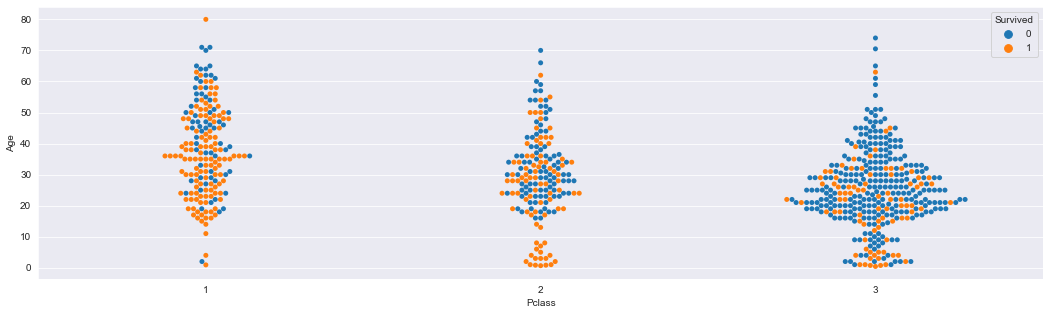

In [36]:
fix, ax = plt.subplots(figsize=(18, 5))
sns.swarmplot(x="Pclass", y="Age", hue="Survived", data=train_data)


As expected a lot of survivors in class 1. It's also interesting to see that there were not a lot of children inb class 1. Maybe rich people don't make a lot of kids?

## Did paying the ticket price influence the chance of survival?

In [37]:
train_data["Fare"].describe()


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

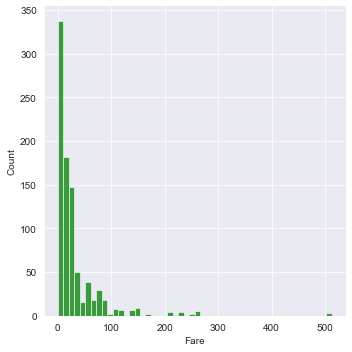

In [38]:
sns.displot(train_data["Fare"], color='g', bins=50)


It's not a normal distribution and it has a huge spike between 0-100. 75% of the people paid under 31$ and the most pricey ticket was 512$.
Maybe we should scale this feature depending on the model.

As befor we should check the correlation between the survival and the fares but the problem is we have too many different values for the Fares. A way of approaching this is to group the fares into categories to visualize them better. The way we decide these categories are looking at the distribution above. This process of cateogrizing numerical features is called binning. We could actually use this new cateogry when training the model. We're not sure it will help but we can check with it and without it.

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

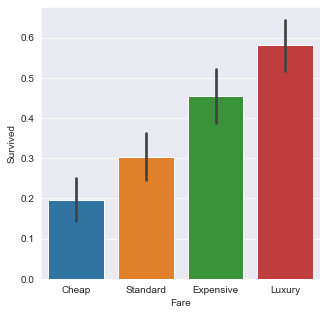

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
fare_categories = pd.qcut(train_data["Fare"], 4, labels=['Cheap', 'Standard', 'Expensive',
                                                         'Luxury'])  # This splits it based on %: 0 0.25 0.5 0.75 1
sns.barplot(x=fare_categories, y=train_data["Survived"], ax=ax)


It's pretty clear to see that chances of survivability clearly go up with the Fare price.
* Cheap (0-25% of max price) Survival Rate 0.2
* Standard (25-50% of max price) Survival Rate 0.3
* Expensive (50-75% of max price) Survival Rate 0.45
* Luxury (75-100% of max price) Survival Rate 0.55

We can also check the relationship between the fare, sex and survival rate to understand more about the importance of the fare:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Sex', ylabel='Fare'>

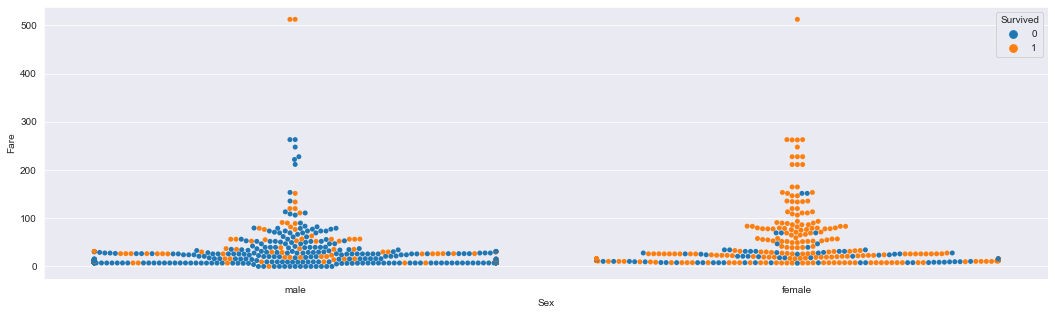

In [40]:
fix, ax = plt.subplots(figsize=(18, 5))
sns.swarmplot(x="Sex", y="Fare", hue="Survived", data=train_data)


We can see some more things with this. All people, no matter the sex with tickets above 500 survived.
All male passengers between 200-300 died but all women between 200-300 survived. Interesting.
All of these are patterns that a classifier can see.

Another thing we can see in the describe is that the smallest Fare paid was 0.0 .This does not seem right. Let's check out who these people were:

In [41]:
train_data.loc[train_data["Fare"] == 0]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


Not a lot of info except maybe the fact that they were all men, they all embarked at Southampton and all except 1 of them died.
Maybe they didnt pay because they were reporters, family members of the crew or something else.

Besides these, since it doesn't make sense for Fare prices to be 0 we will replace them with NaN and we will fill them with the imputed using the median later when we feature engineer:

In [42]:
train_data.loc[train_data["Fare"] == 0, "Fare"] = np.NaN
test_data.loc[train_data["Fare"] == 0, "Fare"] = np.NaN

## Could the place of embarkation influence the chance of survival?
Logic would tell us that the embarkation place should not matter at all but we should investigate it and not make assumptions about the data.
We count count how many embarkations we has at each location and plot them:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Embarked', ylabel='count'>

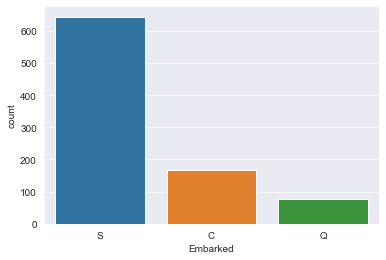

In [43]:
sns.countplot(train_data["Embarked"])


In [44]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [45]:
train_data.groupby("Embarked")["Survived"].value_counts(normalize=True)

Embarked  Survived
C         1           0.553571
          0           0.446429
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: Survived, dtype: float64

We can also plot it against survival rate to see any connections there:

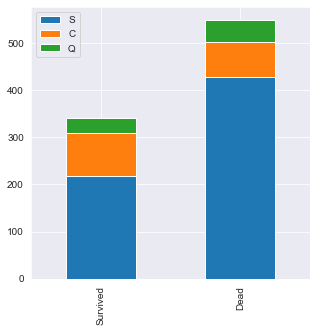

In [46]:
survival_chart_stacked(train_data, "Embarked")

<AxesSubplot:xlabel='Embarked', ylabel='count'>

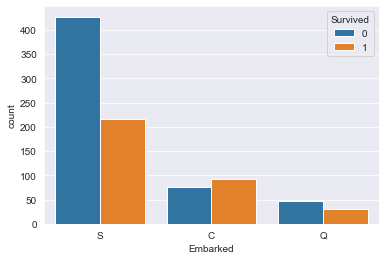

In [47]:
sns.countplot(x="Embarked", hue="Survived", data=train_data)


We can see that most of the passengers embarked at Southampton. However, only 33% survived. The passengers from Cherbourg have the highest survival rate of 55%.
It's always important to not make prios assumptions we should use common sense all the time.Why should the place of embarkation influence the survival rate? Why is the likelihood higher at Cherbourg.

## Was the high number of survivors that embarked at Cherbourg due to a high number of Class 1 passengers?
We know the class increases the chance of survival so let's check if there's more class 1 passengers at Cherbourg vs the rest.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

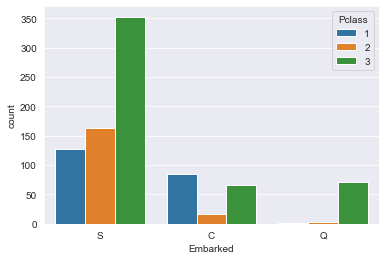

In [48]:
sns.countplot(x="Embarked", hue="Pclass", data=train_data)


In [49]:
train_data.groupby(["Embarked", "Pclass"])["Survived"].sum()


Embarked  Pclass
C         1         59
          2          9
          3         25
Q         1          1
          2          2
          3         27
S         1         74
          2         76
          3         67
Name: Survived, dtype: int64

Hey, our assumption was correct it seems. The majority of people that embarked at Cherbourg were class 1.
In contrast, the majority that embarked at Southampton were class 3.

Even so, going back to the survival percentages it's not clear why the survival rate for Queenstown is slightly higher (38.9% > 33%) than Southampton even though the number of class 1 passengers in relation to class 3 passengers is higher for Southampton.
Maybe the difference is in the ration of males vs females.

## Is gender distribution responsible for the slightly higher passenger survival rate in Queenstown compared to Southampton?

<AxesSubplot:xlabel='Embarked', ylabel='count'>

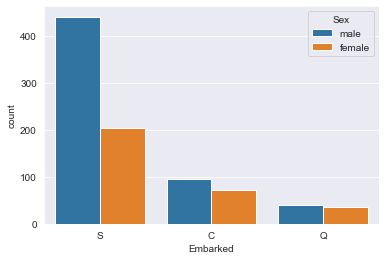

In [50]:
sns.countplot(x="Embarked", hue="Sex", data=train_data)


Yea, this confirms what we thought... More than twice as many men embarked at Southampton than women as opposed to Queenstown where it's roughly the same number of men and women. It shown again how much the gender matters for survival.

## Does the number of children/siblings/spouses or parents on board influence the chance of survival?

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

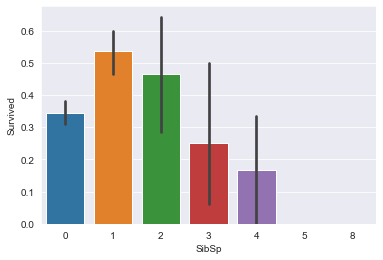

In [51]:
sns.barplot(x="SibSp", y="Survived", data=train_data)


<AxesSubplot:xlabel='SibSp', ylabel='count'>

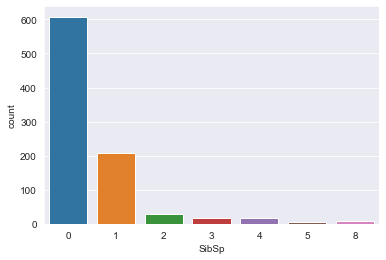

In [52]:
sns.countplot(x="SibSp", data=train_data)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

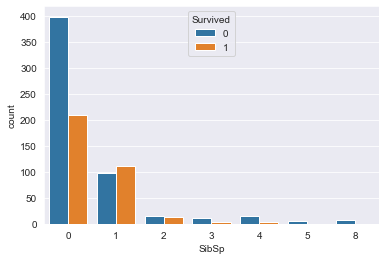

In [53]:
sns.countplot(x="SibSp", hue="Survived", data=train_data)


In [54]:
train_data.groupby("SibSp")["Survived"].value_counts(normalize=True)

SibSp  Survived
0      0           0.654605
       1           0.345395
1      1           0.535885
       0           0.464115
2      0           0.535714
       1           0.464286
3      0           0.750000
       1           0.250000
4      0           0.833333
       1           0.166667
5      0           1.000000
8      0           1.000000
Name: Survived, dtype: float64

We can see that the majority of the passenges travelled alone. Also, looking at the last graph we can also deduce that the more siblings a passenger had the smaller the chance of survival. It's worth noting that we can see an increase in survival chance if a passenger had 1 or 2 siblings but it falls fast for anything higher.

Let's also check the parents and children which is in the Parch feature:

<AxesSubplot:xlabel='Parch', ylabel='count'>

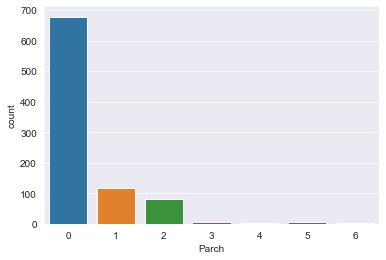

In [55]:
sns.countplot(x="Parch", data=train_data)


<AxesSubplot:xlabel='Parch', ylabel='Survived'>

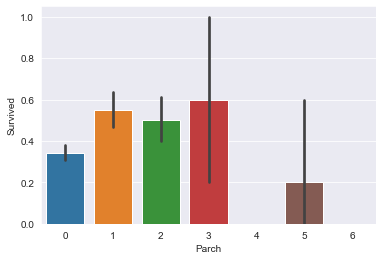

In [56]:
sns.barplot(x="Parch", y="Survived", data=train_data)


<AxesSubplot:xlabel='Parch', ylabel='count'>

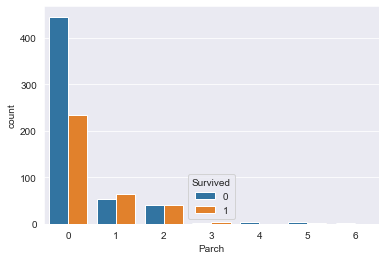

In [57]:
sns.countplot(x="Parch", hue="Survived", data=train_data)


In [58]:
train_data.groupby("Parch")["Survived"].value_counts(normalize=True)

Parch  Survived
0      0           0.656342
       1           0.343658
1      1           0.550847
       0           0.449153
2      0           0.500000
       1           0.500000
3      1           0.600000
       0           0.400000
4      0           1.000000
5      0           0.800000
       1           0.200000
6      0           1.000000
Name: Survived, dtype: float64

We see the same thing here as we saw with the siblings. We can see that small families (2-4 members) had a higher chance of survival than large families or people who travelled alone.

We learned a lot about the data. Let's get to some feature engineering to see what we can improve.

# Feature Engineering
## Adding a Title feature
Let's look at the name feature because we avoided it until now. In theory a person's name should not have any importance related to survivability but let's look at the values

In [59]:
train_data['Name']


0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

It seems that a title can be present in the name, we see that for most of them actually. How about we turn that into a feature that might be useful. Keeping the names as cateogrical values does not make any sense though. Let's make a piece of code that extracts the title from a string.

In [60]:
train_data['Title'] = train_data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [61]:
train_data['Title'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Title
Non-Null Count  Dtype 
--------------  ----- 
891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


Cool, our code works and there are no null values in the new feature, let's look at its values:

In [62]:
train_data['Title'].value_counts()


Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Some are outliers. Let's replace them and put outlier male titles in Mr and outlier female titles in Miss

In [63]:
train_data = train_data.replace({
    'Title': {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'the Countess': 'Mrs', 'Don': 'Mr', 'Mme': 'Mrs',
              'Ms': 'Miss', 'Lady': 'Miss', 'Sir': 'Mr', 'Capt': 'Mr', 'Jonkheer': 'Mr'}
})

train_data['Title'].value_counts()


Mr        525
Miss      186
Mrs       127
Master     40
Dr          7
Rev         6
Name: Title, dtype: int64

Looks good. Let's check it's relatability with the Survival Rate:

<AxesSubplot:xlabel='Title', ylabel='count'>

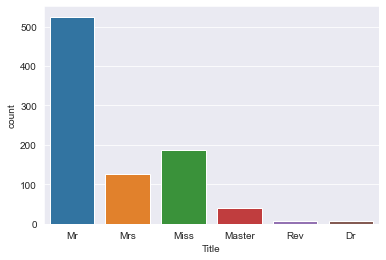

In [64]:
sns.countplot(x="Title", data=train_data)


<AxesSubplot:xlabel='Title', ylabel='Survived'>

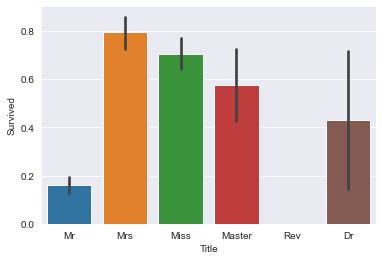

In [65]:
sns.barplot(x="Title", y="Survived", data=train_data)

<AxesSubplot:xlabel='Title', ylabel='count'>

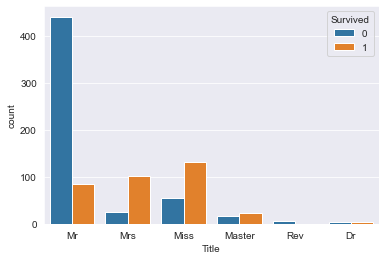

In [66]:
sns.countplot(x="Title", hue='Survived', data=train_data)


This new feature mas potential. We can see that female titles have high survival rates.
Also, Master and Dr titles have a suprisingly high survival rate even though they are male titles.
Being a Mr however has a small survival rate of 15%.
All of the revenant died. Revenants are corpses that come back to life. No idea why this title is in the set:)). Maybe they finally accepted their fate.

## Cabin and Ticket Features

In [67]:
train_data[['Cabin', 'Ticket']]


,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,B42,112053
888,NaN,W./C. 6607
889,C148,111369


Weird values for both of them... Cabin has a lot of missing values and the ticket values is all over the place.
We can try a few things:
* we can keep the first 2 letters of the ticket
* we can keep the number of chars in the ticket
* we can count the number of cabins used (they're separated by a space in the value)
* we can keep the first letter of the cabin

In [68]:
train_data['Ticket_2letter'] = train_data['Ticket'].apply(lambda ticket: ticket[:2])
train_data['Ticket_len'] = train_data['Ticket'].apply(lambda ticket: len(ticket))

train_data['Cabin_sum'] = train_data[~train_data['Cabin'].isna()]['Cabin'].apply(lambda cabin: len(str(cabin).split()))
train_data['Cabin_1letter'] = train_data[~train_data['Cabin'].isna()]['Cabin'].apply(lambda cabin: str(cabin)[:1])


## Adding a Family Size Feature
We can combine Parch and SibSp can be added together since they behave the similarly

In [69]:
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch'] + 1  #the 1 is the person. he's part of the family


<AxesSubplot:xlabel='Family_Size', ylabel='Survived'>

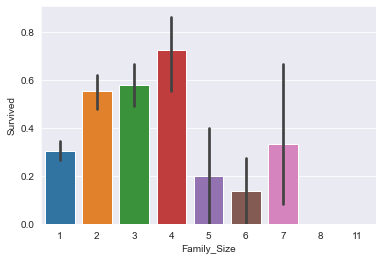

In [70]:
sns.barplot(x="Family_Size", y="Survived", data=train_data)


<AxesSubplot:xlabel='Family_Size', ylabel='count'>

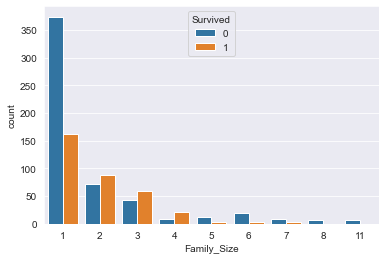

In [71]:
sns.countplot(x="Family_Size", hue='Survived', data=train_data)


We can engineer it even more since we see a pattern introducing a family type by separating into 4 distinct groups

In [72]:
train_data['Family_Type'] = pd.cut(train_data['Family_Size'], [0, 1, 4, 7, 11],
                                   labels=['Alone', 'Small', 'Big', 'Very Big'])


<AxesSubplot:xlabel='Family_Type', ylabel='Survived'>

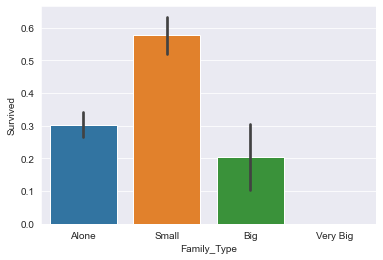

In [73]:
sns.barplot(x="Family_Type", y="Survived", data=train_data)


<AxesSubplot:xlabel='Family_Type', ylabel='count'>

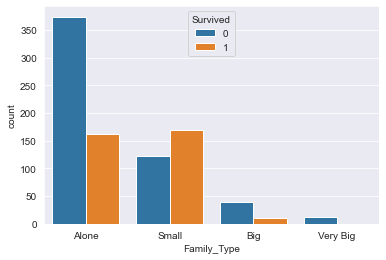

In [74]:
sns.countplot(x="Family_Type", hue='Survived', data=train_data)


## Binning the age

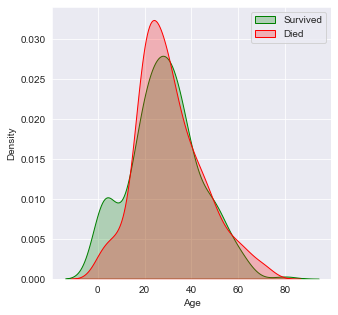

In [75]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(train_data[train_data["Survived"] == 1]["Age"], shade=True, ax=ax, label="Survived", color='g')
sns.kdeplot(train_data[train_data["Survived"] == 0]["Age"], shade=True, ax=ax, label="Died", color='r')
plt.legend()

In [76]:
train_data["Age_Group"] = pd.cut(train_data["Age"], [0, 15, 30, 45, 60, 100],
                                 labels=['Child', 'Young Adult', 'Adult', 'Old', 'Very Old'])


<AxesSubplot:xlabel='Age_Group', ylabel='count'>

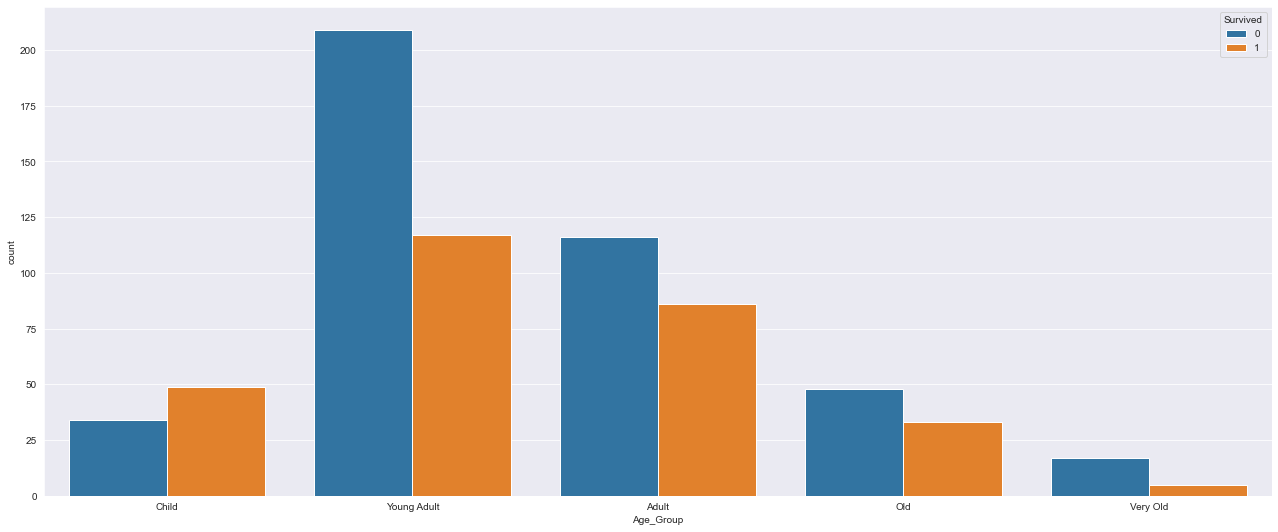

In [77]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age_Group', hue='Survived', data=train_data)


## Binning the Fares

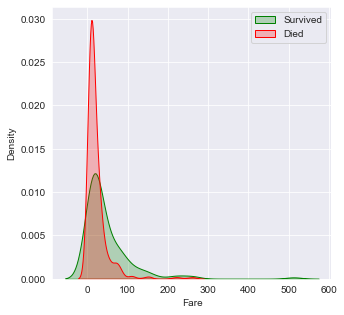

In [78]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(train_data[train_data["Survived"] == 1]["Fare"], shade=True, ax=ax, label="Survived", color='g')
sns.kdeplot(train_data[train_data["Survived"] == 0]["Fare"], shade=True, ax=ax, label="Died", color='r')
plt.legend()

In [79]:
train_data["Fare_Group"] = pd.qcut(train_data["Fare"], 4, labels=['Cheap', 'Standard', 'Expensive',
                                                                  'Luxury'])


<AxesSubplot:xlabel='Fare_Group', ylabel='count'>

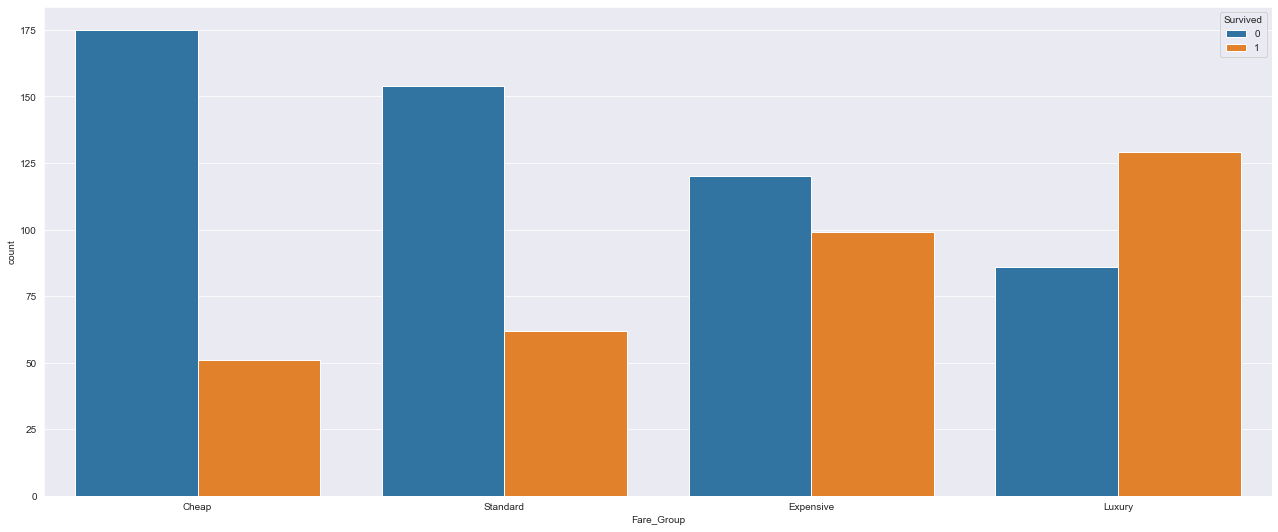

In [80]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare_Group', hue='Survived', data=train_data)


## Are there any redundant features?

Let's start with the sex and the Title. In theory the Sex should be now encoded in the title if the data is consistent.

In [81]:
train_data.groupby("Title")["Sex"].value_counts()


Title   Sex   
Dr      male        6
        female      1
Master  male       40
Miss    female    186
Mr      male      525
Mrs     female    127
Rev     male        6
Name: Sex, dtype: int64

Good enough. Most title are sex specific except the Dr where we have one outlier.

We know small children have a higher chance of survival. Is this information encoded somewhere else? Like in the Title?

In [82]:
train_data[train_data["Age"] <= 12]["Title"].value_counts()


Master    36
Miss      32
Mr         1
Name: Title, dtype: int64

No, doesn't seem like it.

# Automating the entire transformation flow by building a pipeline

In [83]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Name            891 non-null    object  
 4   Sex             891 non-null    object  
 5   Age             714 non-null    float64 
 6   SibSp           891 non-null    int64   
 7   Parch           891 non-null    int64   
 8   Ticket          891 non-null    object  
 9   Fare            876 non-null    float64 
 10  Cabin           204 non-null    object  
 11  Embarked        889 non-null    object  
 12  Title           891 non-null    object  
 13  Ticket_2letter  891 non-null    object  
 14  Ticket_len      891 non-null    int64   
 15  Cabin_sum       204 non-null    float64 
 16  Cabin_1letter   204 non-null    object  
 17  Family_Size     

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('category_encoder', OneHotEncoder())
])

from sklearn.base import BaseEstimator, TransformerMixin


class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_data = X.copy()
        new_data.loc[new_data["Fare"] == 0, "Fare"] = np.NaN

        new_data['Title'] = new_data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
        new_data = new_data.replace({
            'Title': {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'the Countess': 'Mrs', 'Don': 'Mr', 'Mme': 'Mrs',
                      'Ms': 'Miss', 'Lady': 'Miss', 'Sir': 'Mr', 'Capt': 'Mr', 'Jonkheer': 'Mr', 'Dona': 'Mrs', 'Dr': 'Other',
                      'Rev': 'Other'}
        })

        new_data['Ticket_2letter'] = new_data['Ticket'] \
            .apply(lambda ticket: ticket[:2])
        new_data['Ticket_len'] = new_data['Ticket'] \
            .apply(lambda ticket: len(ticket))

        new_data['Cabin_sum'] = new_data[~new_data['Cabin'].isna()]['Cabin'] \
            .apply(lambda cabin: len(str(cabin).split()))
        new_data['Cabin_1letter'] = new_data[~new_data['Cabin'].isna()]['Cabin'] \
            .apply(lambda cabin: str(cabin)[:1])

        new_data['Family_Size'] = new_data['SibSp'] + new_data[
            'Parch'] + 1  #the 1 is the person. he's part of the family
        new_data['Family_Type'] = pd.cut(new_data['Family_Size'], [0, 1, 4, 7, 11],
                                         labels=['Alone', 'Small', 'Big', 'Very Big'])

        new_data["Age_Group"] = pd.cut(new_data["Age"], [0, 15, 30, 45, 60, 100],
                                       labels=['Child', 'Young Adult', 'Adult', 'Old', 'Very Old'])

        new_data["Fare_Group"] = pd.qcut(new_data["Fare"], 4, labels=['Cheap', 'Standard', 'Expensive',
                                                                      'Luxury'])

        return new_data


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[num_attribs + cat_attribs]

## Let's test it with various features enabled and disabled:

Create a function to do this in an easier way

In [85]:
def train_models_with_features(data, labels, num_attribs, cat_attribs):
    full_transformer_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs)
    ])

    full_pipeline = Pipeline([
        ('feature_adder', FeatureAdder()),
        ('feature_selector', FeatureSelector()),
        ('transformer', full_transformer_pipeline),
    ])

    titanic_data_prepared = full_pipeline.fit_transform(data)
    forest_scores = cross_val_score(forest_clf, titanic_data_prepared, labels, cv=10)
    print("Forest mean:", forest_scores.mean())
    svm_scores = cross_val_score(svm_clf, titanic_data_prepared, labels, cv=10)
    print("SVM mean:", svm_scores.mean())

Split the data first

In [86]:
train_data = load_titanic_data("train.csv")
titanic_data = train_data.drop("Survived", axis=1)
titanic_labels = train_data["Survived"].copy()

## 1. Age vs Age_group

In [87]:
num_attribs = ["Pclass"]
cat_attribs = ["Sex", "Embarked", "Title", "Family_Type", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8204744069912608
SVM mean: 0.8327715355805243


In [88]:
num_attribs = ["Pclass", "Age"]
cat_attribs = ["Sex", "Embarked", "Title", "Family_Type", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8047815230961298
SVM mean: 0.8327715355805243


In [89]:
num_attribs = ["Pclass"]
cat_attribs = ["Sex", "Embarked", "Title", "Family_Type", "Fare_Group", "Age_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8204619225967541
SVM mean: 0.8316479400749064


Age group seems to add value and does not fuck up the SVM score a lot. Help forest model more though.

## 2. Title vs Sex
We're checking this because in theory Sex should be encoded in the Title feature.

In [90]:
num_attribs = ["Pclass"]
cat_attribs = ["Embarked", "Family_Type", "Fare_Group", "Age_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.7183770287141072
SVM mean: 0.7138826466916355


In [91]:
num_attribs = ["Pclass"]
cat_attribs = ["Sex", "Embarked", "Family_Type", "Fare_Group", "Age_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8260923845193506
SVM mean: 0.8159300873907614


In [92]:
num_attribs = ["Pclass"]
cat_attribs = ["Title", "Embarked", "Family_Type", "Fare_Group", "Age_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.821598002496879
SVM mean: 0.8294007490636706


In [93]:
num_attribs = ["Pclass"]
cat_attribs = ["Sex", "Title", "Embarked", "Family_Type", "Fare_Group", "Age_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8215730337078652
SVM mean: 0.8316479400749064


It's weird here because Sex and Title together give the best result. We need to keep one though because it makes no sense to have redundant features.
We'll go with the Title because it has more info.

## 3. Fare vs Fare_Group

In [94]:
num_attribs = ["Pclass"]
cat_attribs = ["Title", "Embarked", "Family_Type", "Age_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.809250936329588
SVM mean: 0.8305243445692885


In [95]:
num_attribs = ["Pclass", "Fare"]
cat_attribs = ["Title", "Embarked", "Family_Type", "Age_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8058676654182271
SVM mean: 0.8327715355805243


In [96]:
num_attribs = ["Pclass"]
cat_attribs = ["Title", "Embarked", "Family_Type", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8204494382022472
SVM mean: 0.8294007490636706


We'll keep the fare group with 4 categories here. Seems to impact SVM a bit negatively but it's not a lot and the feature makes nore sense.

## 4. Family Size vs Family Type

In [97]:
num_attribs = ["Pclass"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8159675405742821
SVM mean: 0.7935081148564295


In [98]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8193258426966292
SVM mean: 0.8327715355805243


In [99]:
num_attribs = ["Pclass"]
cat_attribs = ["Title", "Embarked", "Family_Type", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8204494382022472
SVM mean: 0.8294007490636706


I have no idea. The family group here does not help a lot even though it should. We'll keep the family size

## 5. Ticket length vs Ticket 2 letters

In [100]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8193258426966292
SVM mean: 0.8327715355805243


In [101]:
num_attribs = ["Pclass", "Family_Size", "Ticket_len"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8137453183520599
SVM mean: 0.8282771535580524


In [102]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group", "Ticket_2letter"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.818214731585518
SVM mean: 0.8148064918851435


Ticket feature seems to be garbage and does not help a lot. We should try and engineer a better feature out of it or drop it.
For now we'll drop it.


## 6. Cabin sum vs Cabin 1 letter
Let's start with a clean run without any Cabin fields

In [103]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8193258426966292
SVM mean: 0.8327715355805243


In [104]:
num_attribs = ["Pclass", "Family_Size", "Cabin_sum"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.818214731585518
SVM mean: 0.8271660424469414


In [105]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group", "Cabin_1letter"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.83167290886392
SVM mean: 0.8260299625468164


This is so weird...Cabin 1 letter helped the forest a lot nad impacted SVM a bit negatively. Let's keep Cabin_1letter

## The prediction with the best features we decided together

In [106]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group", "Cabin_1letter"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.83167290886392
SVM mean: 0.8260299625468164


## Do a prediction with all the fields that helped the SVM to see how the result is
Keeping Age, keeping Title, keeping Fare, keeping Family_Size, dropping Ticket and cabin features

In [107]:
num_attribs = ["Pclass", "Family_Size", "Age", "Fare"]
cat_attribs = ["Title", "Embarked"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8115230961298376
SVM mean: 0.8327840199750313


I mean it's ok... but it's still wore than a previous run:

In [108]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8193258426966292
SVM mean: 0.8327715355805243


It's interesting to see that the age and fare groups together add more value than keeping them numerical.

In [109]:
num_attribs = ["Pclass", "Family_Size"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8215730337078652
SVM mean: 0.8327715355805243


Adding the sex helps but I can't tell why

In [110]:
num_attribs = ["Pclass"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Family_Type"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8193508114856429
SVM mean: 0.8316479400749064


Adding the family type instead of family size makes it much worse...

I just realized that we treated the class a numerical field meaning class 3 might be given more importance. It should be a categorical field...

In [111]:
num_attribs = ["Family_Size"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.817103620474407
SVM mean: 0.8282896379525593


In [112]:
num_attribs = ["Family_Size", "Cabin_sum"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8204619225967541
SVM mean: 0.8260549313358301


In [113]:
num_attribs = ["Family_Size", "Cabin_sum"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass", "Cabin_1letter"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8316978776529339
SVM mean: 0.8226841448189763


For fuck's sake, now the scores are the same. This is both cabin features added

In [114]:
num_attribs = ["Family_Size", "Cabin_sum", "Ticket_len"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)

Forest mean: 0.8137453183520599
SVM mean: 0.8249313358302122


In [115]:
num_attribs = ["Family_Size", "Cabin_sum", "Ticket_len"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass", "Ticket_2letter"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8249063670411985
SVM mean: 0.7979775280898876


Ticket 2 letter is horrible, don't add it. Let's go back.

In [116]:
num_attribs = ["Family_Size", "Cabin_sum", "Ticket_len"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8137453183520599
SVM mean: 0.8249313358302122


In [117]:
num_attribs = ["Family_Size", "Cabin_sum", "Ticket_len"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8137453183520599
SVM mean: 0.8249313358302122


## Ok the best result is this, where Pclass is treated as categorical, we keep both Sex and Title and both Fare instead of Fare Group:

In [118]:
num_attribs = ["Family_Size", "Fare"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Pclass"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.8070037453183522
SVM mean: 0.8372659176029963


The most logical feature selection for me is this:

In [119]:
num_attribs = ["Cabin_sum", "Fare"]
cat_attribs = ["Title", "Embarked", "Age_Group", "Fare_Group", "Pclass", "Family_Type"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.81374531835206
SVM mean: 0.8249188514357053


However, this is more that 1% worse that the best so far.

# Fine-tuning hyperparams

In [120]:
from scipy.stats import reciprocal, expon
from sklearn.model_selection import RandomizedSearchCV

num_attribs = ["Family_Size", "Fare"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Pclass"]

full_transformer_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

full_pipeline = Pipeline([
    ('feature_adder', FeatureAdder()),
    ('feature_selector', FeatureSelector()),
    ('transformer', full_transformer_pipeline),
])

titanic_data_prepared = full_pipeline.fit_transform(titanic_data)

param_distribs = {
    'kernel': ['rbf'],
    'C': reciprocal(1, 200000),
    'gamma': ['auto'],
}

rnd_search = RandomizedSearchCV(svm_clf, param_distributions=param_distribs, n_iter=50, cv=10, verbose=2,
                                random_state=42)
rnd_search.fit(titanic_data_prepared, titanic_labels)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........C=96.70488316937897, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......C=109588.51843286837, gamma=auto, kernel=rbf; total time=   0.7s
[CV] END .......C=109588.51843286837, gamma=au

RandomizedSearchCV(cv=10, estimator=SVC(gamma='auto'), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CAB0419DC0>,
                                        'gamma': ['auto'], 'kernel': ['rbf']},
                   random_state=42, verbose=2)

In [121]:
rnd_search.best_score_

0.8384019975031209

Not bad, 83.8 % asccuracy.

In [122]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)


0.8160049937578029 {'C': 96.70488316937897, 'gamma': 'auto', 'kernel': 'rbf'}
0.776716604244694 {'C': 109588.51843286837, 'gamma': 'auto', 'kernel': 'rbf'}
0.7991510611735331 {'C': 7591.3994172066905, 'gamma': 'auto', 'kernel': 'rbf'}
0.8126342072409487 {'C': 1491.0993534221182, 'gamma': 'auto', 'kernel': 'rbf'}
0.8327715355805243 {'C': 6.715208365130137, 'gamma': 'auto', 'kernel': 'rbf'}
0.8327715355805243 {'C': 6.713231619759599, 'gamma': 'auto', 'kernel': 'rbf'}
0.8372659176029963 {'C': 2.031902994480314, 'gamma': 'auto', 'kernel': 'rbf'}
0.7789637952559301 {'C': 39050.42189404142, 'gamma': 'auto', 'kernel': 'rbf'}
0.8126342072409487 {'C': 1536.4863560723961, 'gamma': 'auto', 'kernel': 'rbf'}
0.802521847690387 {'C': 5669.098123087404, 'gamma': 'auto', 'kernel': 'rbf'}
0.8361423220973784 {'C': 1.285638950805229, 'gamma': 'auto', 'kernel': 'rbf'}
0.7778401997503119 {'C': 138522.7865778499, 'gamma': 'auto', 'kernel': 'rbf'}
0.78458177278402 {'C': 25870.4157773626, 'gamma': 'auto', 'ker

In [123]:
rnd_search.best_estimator_


SVC(C=23.53967403885428, gamma='auto')

Let's finally do it on the test set and generate the submission CSV.

In [124]:
num_attribs = ["Family_Size", "Fare"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Pclass"]

full_transformer_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

full_pipeline = Pipeline([
    ('feature_adder', FeatureAdder()),
    ('feature_selector', FeatureSelector()),
    ('transformer', full_transformer_pipeline),
])

titanic_train_prepared = full_pipeline.fit_transform(titanic_data)


test_data = load_titanic_data("test.csv")

best_svc = rnd_search.best_estimator_
best_svc.fit(titanic_train_prepared, titanic_labels)

titanic_test_prepared = full_pipeline.transform(test_data)
titanic_predictions = best_svc.predict(titanic_test_prepared)
titanic_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

One important thing is that I had issues with categorical data present in the train set and not in the test set or vice-versa...
When running the sets through the pipeline and calling fit_transform on both the fitting is done for each separately and the one hot encoder learns the categories looking at each set. This means if a category is missing from the test set it will result in 1 column less after encoding and it will screw everything up.
To avoid this situation when the test set might not have all categories, we need to fit the pipeline (and thus the encoder) on the train set and only call transform on the training set. However this includes other potential issues. If we don't fit on the test set all fit information from the training set will be used like imputed medians, most frequest, one hot categories and anything else that's done in the fit method and set's an internal variable of a transformer.

In [125]:
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": titanic_predictions
})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [126]:
submission.to_csv("titanic_submission_svc.csv", index=False)


# Let's try to maximize a Random Forest


In [127]:
num_attribs = ["Cabin_sum"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass", "Cabin_1letter", "Family_Type"]

train_models_with_features(titanic_data, titanic_labels, num_attribs, cat_attribs)


Forest mean: 0.840661672908864
SVM mean: 0.8294132334581772


Let's do a grid search

In [128]:
from sklearn.model_selection import GridSearchCV

num_attribs = ["Cabin_sum"]
cat_attribs = ["Sex", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass", "Cabin_1letter", "Family_Type"]

full_transformer_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

full_pipeline = Pipeline([
    ('feature_adder', FeatureAdder()),
    ('feature_selector', FeatureSelector()),
    ('transformer', full_transformer_pipeline),
])

titanic_train_prepared = full_pipeline.fit_transform(titanic_data)

param_grid = [
    {'n_estimators': [100], 'max_features': [25], 'max_depth': [6], 'oob_score':[True, False]}
]

grid_search = GridSearchCV(forest_clf, param_grid, cv=10, verbose=2)
grid_search.fit(titanic_train_prepared, titanic_labels)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_depth': [6], 'max_features': [25],
                          'n_estimators': [100], 'oob_score': [True, False]}],
             verbose=2)

In [129]:
grid_search.best_score_


0.8440324594257179

In [130]:
grid_search.best_estimator_


RandomForestClassifier(max_depth=6, max_features=25, oob_score=True,
                       random_state=42)

In [131]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

titanic_train_prepared = full_pipeline.fit_transform(train_data)

best_forest = grid_search.best_estimator_
best_forest.fit(titanic_train_prepared, titanic_labels)


titanic_test_prepared = full_pipeline.transform(test_data)
titanic_predictions_forest = best_forest.predict(titanic_test_prepared)
titanic_predictions_forest

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [132]:
one_hot_categories = list(np.concatenate(full_pipeline['transformer'].named_transformers_["cat"]['category_encoder'].categories_).flat)
attributes = num_attribs + one_hot_categories
sorted(zip(best_forest.feature_importances_, attributes), reverse=True)

[(0.29333289716450395, 'Mr'),
 (0.12910064938235663, 'male'),
 (0.10806777364135617, 3),
 (0.075224584902167, 'female'),
 (0.042604395539630684, 'Big'),
 (0.03881178661964056, 1),
 (0.027890575574988103, 'Small'),
 (0.023065322812050773, 'C'),
 (0.021206642344644405, 'Other'),
 (0.0202362543797653, 'S'),
 (0.020034355156037277, 'Adult'),
 (0.017753483206075234, 'Master'),
 (0.016723332846991554, 'Expensive'),
 (0.015518703162109952, 'Child'),
 (0.015364696095324103, 'Luxury'),
 (0.014050928165825993, 'Cheap'),
 (0.012173448005353969, 'E'),
 (0.010917189412104933, 'Standard'),
 (0.010631984546653312, 'Alone'),
 (0.009651630474672013, 'Old'),
 (0.009622692438759678, 'Young Adult'),
 (0.008954714441665627, 'C'),
 (0.008420058158152452, 2),
 (0.008419061616181027, 'Mrs'),
 (0.00812059155365604, 'Very Big'),
 (0.0064801640615258175, 'Very Old'),
 (0.006124705008776874, 'Cabin_sum'),
 (0.005466249299835441, 'Miss'),
 (0.004614943466601035, 'D'),
 (0.003680548359357216, 'Q'),
 (0.003417465049

In [133]:
submission_forest = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": titanic_predictions_forest
})
submission_forest


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [134]:
submission_forest.to_csv("titanic_submission_forest.csv", index=False)


Let's try a random forest setup stolen from the internet:

In [135]:
stolen_forest = RandomForestClassifier(criterion='gini',
                       n_estimators=1750,
                       max_depth=7,
                       min_samples_split=6,
                       min_samples_leaf=6,
                       max_features='auto',
                       oob_score=True,
                       random_state=42,
                       n_jobs=-1,
                       verbose=1)
stolen_forest.fit(titanic_train_prepared, titanic_labels)
stolen_forest_predictions = stolen_forest.predict(titanic_test_prepared)
stolen_forest_predictions


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [136]:
stolen_submission_forest = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": stolen_forest_predictions
})
submission_forest.to_csv("titanic_submission_forest_stolen.csv", index=False)


# A new approach

In [137]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

## Dealing with missing values in a more specific way

In [138]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's start by looking at the age. Instead of using the median of the column for all missing value let's check the Age correlations first.

In [139]:
corr_matrix = train_data.corr()
corr_matrix["Age"]

PassengerId    0.036847
Survived      -0.077221
Pclass        -0.369226
Age            1.000000
SibSp         -0.308247
Parch         -0.189119
Fare           0.096067
Name: Age, dtype: float64

Class has a strong correlation with Age so let's calculate the median for the age grouped by sex and class:

In [140]:
age_by_pclass_sex = train_data.groupby(['Sex', 'Pclass']).median()['Age']
age_by_pclass_sex


Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [141]:
train_data['Age'] = train_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda  age: age.fillna(age.median()))

In [142]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cool, we filled the missing values in the Age. Let's sort out the embarked. Here's we'll use the most frequest value of S:

In [143]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].value_counts().idxmax())


In [144]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We sorted out the Embarked too. Let's look at the Fare now:

For the fare we will continue doing what we did so fare. The 0 ticket values, we can set them to NaN then set the median

In [145]:
train_data.loc[train_data["Fare"] == 0, "Fare"] = np.NaN


In [146]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         876 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [147]:
train_data['Fare'] = titanic_data['Fare'].fillna(train_data['Fare'].median())


In [148]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Now for the Cabin. A lot of missing values. The prefix of the cabin is important and it represents the layout of the ship. For missing values we'll set a value 'Missing'

In [149]:
train_data['Deck'] = train_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'Missing')


In [150]:
idx = train_data[train_data['Deck'] == 'T'].index
train_data.loc[idx, 'Deck'] = 'A'
train_data['Deck'] = train_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
train_data['Deck'] = train_data['Deck'].replace(['D', 'E'], 'DE')
train_data['Deck'] = train_data['Deck'].replace(['F', 'G'], 'FG')

train_data['Deck'].value_counts()

Missing    687
ABC        122
DE          65
FG          17
Name: Deck, dtype: int64

In [151]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Deck         891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


We should now drop the cabin feature

In [152]:
train_data = train_data.drop("Cabin", axis=1)


In [153]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Deck         891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We fixed all of our missing fields.

## Feature Engineering
# Fare
We'll do the same as we did

## Age
We'll do the same as we did

## Family Size and Family Type
We'll do the same as we did

## Ticket
We'll consider how many time that ticket is used as a better feature

In [154]:
train_data['Ticket_Frequency'] = train_data.groupby('Ticket')['Ticket'].transform('count')


## We'll keep the Title the same

# Do another pipeline for this entire thing

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('category_encoder', OneHotEncoder())
])

from sklearn.base import BaseEstimator, TransformerMixin

class MissingValuesFiller(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_data = X.copy()

        new_data['Age'] = new_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda  age: age.fillna(age.median()))
        new_data['Embarked'] = new_data['Embarked'].fillna(new_data['Embarked'].value_counts().idxmax())

        new_data.loc[new_data["Fare"] == 0, "Fare"] = np.NaN
        new_data['Fare'] = new_data['Fare'].fillna(new_data['Fare'].median())

        return new_data


class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        new_data = X.copy()

        new_data['Title'] = new_data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
        new_data = new_data.replace({
            'Title': {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'the Countess': 'Mrs', 'Don': 'Mr', 'Mme': 'Mrs',
                      'Ms': 'Miss', 'Lady': 'Miss', 'Sir': 'Mr', 'Capt': 'Mr', 'Jonkheer': 'Mr', 'Dona': 'Mrs', 'Dr': 'Other',
                      'Rev': 'Other'}
        })

        new_data['Family_Size'] = new_data['SibSp'] + new_data[
            'Parch'] + 1  #the 1 is the person. he's part of the family
        new_data['Family_Type'] = pd.cut(new_data['Family_Size'], [0, 1, 4, 7, 11],
                                         labels=['Alone', 'Small', 'Big', 'Very Big'])

        new_data["Age_Group"] = pd.cut(new_data["Age"], [0, 15, 30, 45, 60, 100],
                                       labels=['Child', 'Young Adult', 'Adult', 'Old', 'Very Old'])

        new_data["Fare_Group"] = pd.qcut(new_data["Fare"], 4, labels=['Cheap', 'Standard', 'Expensive',
                                                                      'Luxury'])

        new_data['Ticket_Frequency'] = new_data.groupby('Ticket')['Ticket'].transform('count')

        new_data['Deck'] = new_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'Missing')

        idx = new_data[new_data['Deck'] == 'T'].index
        new_data.loc[idx, 'Deck'] = 'A'
        new_data['Deck'] = new_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
        new_data['Deck'] = new_data['Deck'].replace(['D', 'E'], 'DE')
        new_data['Deck'] = new_data['Deck'].replace(['F', 'G'], 'FG')

        return new_data


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[num_attribs + cat_attribs]


In [156]:
train_data = load_titanic_data("train.csv")
titanic_data = train_data.drop("Survived", axis=1)
titanic_labels = train_data["Survived"].copy()

num_attribs = ["Ticket_Frequency"]
cat_attribs = ["Sex", "Deck", "Title", "Embarked", "Age_Group", "Fare_Group", "Pclass", "Family_Type"]

full_transformer_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

full_pipeline = Pipeline([
    ('missing_values_filler', MissingValuesFiller()),
    ('feature_adder', FeatureAdder()),
    ('feature_selector', FeatureSelector()),
    ('transformer', full_transformer_pipeline),
])

titanic_train_prepared = full_pipeline.fit_transform(titanic_data)

param_grid = [
    {'n_estimators': [100], 'max_features': [25], 'max_depth': [6], 'oob_score':[True, False]}
]

grid_search = GridSearchCV(forest_clf, param_grid, cv=10, verbose=2)
grid_search.fit(titanic_train_prepared, titanic_labels)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.2s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=6, max_features=25, n_estimators=100, oob_score=True; total time=   0.1s
[CV] END max_depth=

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_depth': [6], 'max_features': [25],
                          'n_estimators': [100], 'oob_score': [True, False]}],
             verbose=2)

In [157]:
grid_search.best_score_


0.8417602996254683

In [158]:
grid_search.best_estimator_


RandomForestClassifier(max_depth=6, max_features=25, oob_score=True,
                       random_state=42)

In [159]:
one_hot_categories = list(np.concatenate(full_pipeline['transformer'].named_transformers_["cat"]['category_encoder'].categories_).flat)
attributes = num_attribs + one_hot_categories
sorted(zip(grid_search.best_estimator_.feature_importances_, attributes), reverse=True)


[(0.335024930566689, 'Mr'),
 (0.10292841408011456, 3),
 (0.09671117925818612, 'male'),
 (0.09377460321373779, 'Ticket_Frequency'),
 (0.07085288610650883, 'female'),
 (0.03365707778521075, 'Missing'),
 (0.023434541036133308, 'Other'),
 (0.02157276832585307, 'Small'),
 (0.019757654371334907, 'Adult'),
 (0.018961896866801293, 1),
 (0.017933601530976735, 'S'),
 (0.01566318649503938, 'Expensive'),
 (0.014818600253215613, 'Master'),
 (0.014480198960872414, 'Standard'),
 (0.01394322129295493, 'Big'),
 (0.01315176020336561, 'DE'),
 (0.011591996671306913, 'Child'),
 (0.010985678027774157, 'C'),
 (0.010650577894562564, 'Old'),
 (0.010438170871417437, 'Alone'),
 (0.009921784544933523, 'Young Adult'),
 (0.00784628669019647, 'Luxury'),
 (0.005501975853247765, 'Very Old'),
 (0.005365439819108309, 'Cheap'),
 (0.00509021291598764, 'ABC'),
 (0.004291068364595295, 'Q'),
 (0.0034030805982013666, 'Miss'),
 (0.0032755753565030365, 2),
 (0.0019053464908654178, 'Mrs'),
 (0.0016557176915422453, 'Very Big'),
 

In [160]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

titanic_train_prepared = full_pipeline.fit_transform(train_data)

best_forest = grid_search.best_estimator_
best_forest.fit(titanic_train_prepared, titanic_labels)


titanic_test_prepared = full_pipeline.transform(test_data)
tweaked_predictions_forest = best_forest.predict(titanic_test_prepared)
tweaked_predictions_forest


array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [206]:
tweaked_predictions_forest.shape

(418,)

In [161]:
tweaked_submission_forest = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": tweaked_predictions_forest
})
tweaked_submission_forest.to_csv("titanic_submission_forest_tweaked.csv", index=False)


It's worse than my versions

In [177]:
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [178]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [181]:
X_train.shape

(891, 12)

In [179]:
import tensorflow as tf
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[len(X_train[0])]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2)


Epoch 1/200
45/45 [==============================] - 1s 7ms/step - loss: 0.5316 - accuracy: 0.7388 - val_loss: 0.3740 - val_accuracy: 0.8436
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 0.4654 - accuracy: 0.8048 - val_loss: 0.3640 - val_accuracy: 0.8715
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.8216 - val_loss: 0.3554 - val_accuracy: 0.8436
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.8188 - val_loss: 0.3544 - val_accuracy: 0.8547
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.8174 - val_loss: 0.3379 - val_accuracy: 0.8771
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 0.4083 - accuracy: 0.8301 - val_loss: 0.3268 - val_accuracy: 0.8771
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 0.4046 - accuracy: 0.8244 - val_loss: 0.3313 - val_accuracy: 0.8883
Epoch 8/200
4

In [172]:
results = model.evaluate(X_train, y_train, batch_size=32)
print("test loss, test acc:", results)


28/28 [==============================] - 0s 1ms/step - loss: 0.3197 - accuracy: 0.8934
test loss, test acc: [0.31971243023872375, 0.8933781981468201]


In [174]:
preprocessed_test_data = preprocess_pipeline.transform(test_data)
preprocessed_test_data

array([[ 0.39488658, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.35550962,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.50825727, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.70228595, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [-0.1046374 , -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [-0.1046374 ,  0.43279337,  0.76762988, ...,  1.        ,
         0.        ,  0.        ]])

In [184]:
neural_predictions = model.predict(preprocessed_test_data)


14/14 [==============================] - 0s 763us/step


In [183]:
neural_predictions

array([[9.63271856e-02],
       [6.21203391e-04],
       [3.16287915e-05],
       [6.11185208e-02],
       [5.63425682e-02],
       [1.46541178e-01],
       [7.83535361e-01],
       [2.44599744e-03],
       [4.21519130e-02],
       [7.40199857e-06],
       [7.32872859e-02],
       [3.53358299e-01],
       [1.00000000e+00],
       [3.11833792e-05],
       [1.00000000e+00],
       [9.99999583e-01],
       [6.97405703e-05],
       [2.07340866e-01],
       [4.12307173e-01],
       [2.55365667e-05],
       [9.99983609e-01],
       [9.03952837e-01],
       [9.99999464e-01],
       [9.99998569e-01],
       [1.00000000e+00],
       [1.34756885e-06],
       [1.00000000e+00],
       [3.13191235e-01],
       [9.63032722e-01],
       [6.49617112e-04],
       [2.29867626e-04],
       [2.25410549e-04],
       [5.23148656e-01],
       [6.35016114e-02],
       [8.67256105e-01],
       [1.58907607e-01],
       [4.96038914e-01],
       [6.68876827e-01],
       [4.65842709e-02],
       [7.42620826e-01],


In [185]:
np.round(neural_predictions)


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],

In [210]:
rounded_predictions = (neural_predictions > 0.8).astype('int32')

In [211]:
rounded_predictions = rounded_predictions.flatten()
rounded_predictions.shape

(418,)

In [212]:
neural_submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": rounded_predictions
})
neural_submission.to_csv("titanic_submission_neural.csv", index=False)
